In [1]:
import numpy as np
import scipy.constants as sc
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt

In [2]:
#Constats
#Material
decanol1 = {'m':158.285, #amu
            'n_atom':33, 
            'DOF':99,
            'rho_l':830, #kg m^-3
            'c_l': 1600, #J kg^-1 K^-1
            'p*':1.3, #Pa
            'T*':298.15, #K
            'deltaH_vap':8.1*10**4 #J / mole
        }

#Chamber
chamber = {'Volume V_ch':10**(-2), #m^3
           'Surface area A_ch':0.7, #m^2
           'Pumping speed S_p':50*10**(-3), #m^3 s^-1
           'wall leak flux j_w':3*10**12, #m^-2 s^-1
           'liquid vol V_l':3*10**(-6), #m^3
           'surface area A_l':4.66*10**(-4) #m^2
        }

#Set parameters in use
m, n_atom, D, rho_l, c_l, p_star, T_star, deltaH_vap = decanol1.values()
V_ch, A_ch, S_p, j_w, V_l, A_l = chamber.values()
t_s = 10**3 #tau_s


In [8]:

# Set parameters
m, n_atom, DOF, rho_l, c_l, p_star, T_star, deltaH_vap = decanol1.values()
V_ch, A_ch, S_p, j_w, V_l, A_l = chamber.values()
t_s = 10**3  # tau_s in seconds
p_star = p_star * 1e5  # Convert p* from bar to Pa
m = m * 1.66053907 * 10**(-27)  # Convert mass from atomic units to kg

# Starting values
T_l = 35 + 273.15  # Liquid temperature in K
P_v = 10**(-5)    # Vapor pressure in Pa (initial 0.7 bar)
T_v = 273.15 + 10  # Vapor temperature in K

def delta_valve(t):
    if t > 10:
        return 0
    else:
        return 1

def P_sat(T):
    return p_star * np.log( - deltaH_vap / (sc.k * sc.N_A) * (1/T - 1/T_star) ) #T must be larger than T*

def j_ev(T_l, P_v):
    sigma_e = (P_sat(T_l)/P_v) * np.exp( (DOF +4) * (1 - T_v/T_l) ) * (T_v/T_l) ** (DOF+4)
    sigma_c = np.sqrt( T_v/T_l ) * np.exp( -(DOF+4) * (1 - T_v/T_l) ) * (T_v/T_l) ** (-(DOF + 4))

    return np.sqrt( 1/ (2 * np.pi * m * sc.k) ) * ( sigma_e * P_sat(T_l) / np.sqrt( T_l ) - sigma_c * P_v / np.sqrt( T_l ) )

def system(y, time):
    P_v, T_l, V_l = y
    jev = j_ev(T_l, P_v)

    dp_vdt = A_l / V_ch * sc.k * T_v * jev + A_ch / V_ch * sc.k * T_v * j_w - S_p / V_ch * P_v * delta_valve(time)

    dT_ldt = - A_l * deltaH_vap / ( sc.N_A * rho_l * V_l * c_l ) * jev + ( T_v - T_l) / t_s

    dV_ldt = - m / ( rho_l * A_l ) * jev

    return [dp_vdt, dT_ldt, dV_ldt]


In [9]:
time = np.linspace(0, 10**4, 100000)
solution = odeint(system, y0=np.array([P_v, T_l, V_l]), t=time)

In [10]:
solution

array([[1.00000000e-05, 3.08150000e+02, 3.00000000e-06],
       [8.14233520e-04, 3.08136161e+02, 9.38085281e-87],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [11]:

pressure = [P_v]
liquid_temparature = [T_l]
liquid_volume = [V_l]
time = np.linspace(10**(-1), 10**4, 1000000)

for t in range(len(time)):
    #Calc j_ev
    
    # print(t, time[t])
    delta = 0.01
    #Calculate change
    # dp = A_l/V_ch * sc.k * T_v * j + A_ch/V_ch * sc.k * T_v * j_w - S_p/V_ch * P_v * valve
    # dT =  - ( A_l * deltaH_vap) / ( sc.N_A * rho_l * V_l * c_l) * j + ( T_v - T_l) / t_s
    # dV = - m/(rho_l * A_l) * j
    
    dp, dT, dV = system([pressure[-1], liquid_temparature[-1], liquid_volume[-1]], t)
    # print(P_v,T_l,V_l)
    if t == 1:
        print(pressure,liquid_temparature,liquid_volume)
    #Add change to value
    P_v += dp*delta
    T_l += dT*delta
    V_l += dV*delta

    #Add to list
    pressure.append(P_v)
    liquid_temparature.append(T_l)
    liquid_volume.append(V_l)


C:\Users\andre\AppData\Local\Temp\ipykernel_7568\602373541.py:24: RuntimeWarning: invalid value encountered in sqrt
  sigma_c = np.sqrt( T_v/T_l ) * np.exp( -(DOF+4) * (1 - T_v/T_l) ) * (T_v/T_l) ** (-(DOF + 4))
C:\Users\andre\AppData\Local\Temp\ipykernel_7568\602373541.py:24: RuntimeWarning: overflow encountered in double_scalars
  sigma_c = np.sqrt( T_v/T_l ) * np.exp( -(DOF+4) * (1 - T_v/T_l) ) * (T_v/T_l) ** (-(DOF + 4))
C:\Users\andre\AppData\Local\Temp\ipykernel_7568\602373541.py:26: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt( 1/ (2 * np.pi * m * sc.k) ) * ( sigma_e * P_sat(T_l) / np.sqrt( T_l ) - sigma_c * P_v / np.sqrt( T_l ) )


[1e-05, 88157623930.05388] [308.15, -7613332491.955169] [3e-06, -328850844.02626395]


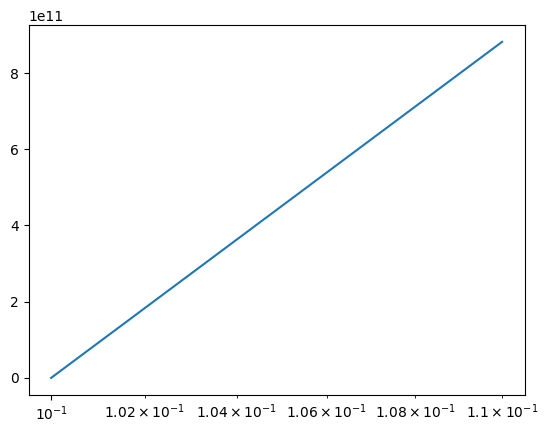

In [7]:
plt.plot(time, pressure[:-1])
plt.xscale("log")

In [176]:
sol = solve_ivp(system, t_span=(0,10**4), y0=np.array([P_v, T_l, V_l]), t_eval=time, method="RK45" )
sol.y


C:\Users\andre\AppData\Local\Temp\ipykernel_7800\2315928056.py:20: RuntimeWarning: invalid value encountered in log
  return p_star * np.log( - deltaH_vap / (sc.k * sc.N_A) * (1/T - 1/T_star) ) #T must be larger than T*
C:\Users\andre\AppData\Local\Temp\ipykernel_7800\2315928056.py:20: RuntimeWarning: divide by zero encountered in log
  return p_star * np.log( - deltaH_vap / (sc.k * sc.N_A) * (1/T - 1/T_star) ) #T must be larger than T*
C:\Users\andre\AppData\Local\Temp\ipykernel_7800\2315928056.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  sigma_c = np.sqrt( T_v/T_l ) * np.exp( -(DOF+4) * (1 - T_v/T_l) ) * (T_v/T_l) ** (-(DOF + 4))
C:\Users\andre\AppData\Local\Temp\ipykernel_7800\2315928056.py:24: RuntimeWarning: invalid value encountered in double_scalars
  sigma_c = np.sqrt( T_v/T_l ) * np.exp( -(DOF+4) * (1 - T_v/T_l) ) * (T_v/T_l) ** (-(DOF + 4))
C:\Users\andre\AppData\Local\Temp\ipykernel_7800\2315928056.py:32: RuntimeWarning: invalid value encountered in 

array([[ 2.96440053e+03,  3.01815554e+03,  3.06294868e+03, ...,
         9.60852969e+05,  9.75140996e+05,  9.98694986e+05],
       [ 3.08148534e+02,  3.08148287e+02,  3.08148041e+02, ...,
         2.98150299e+02,  2.98150150e+02,  2.98150001e+02],
       [-1.52755855e+01, -1.60343857e+01, -1.67690049e+01, ...,
        -4.07732584e+03, -4.13062390e+03, -4.21848640e+03]])

In [14]:
jev = j_ev(T_l, P_v)
print(jev)
A_l / V_ch * sc.k * T_v * jev + A_ch / V_ch * sc.k * T_v * j_w - S_p / V_ch * P_v * delta_valve(1)


nan


nan